In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-15 09:04:35.015441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 09:04:35.015458: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from ML_classes.LinearModel import LinearModel


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

max_value_energy = df["energy(kWh/hh)"].max()
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

In [5]:
# Initiating the class
deep_learner = LinearModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

In [6]:
# Fitting the model

model = deep_learner.LinearModel()

Epoch 1/10
 1/66 [..............................] - ETA: 7s - loss: 0.0317

2022-03-15 09:04:38.409435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 09:04:38.409830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 09:04:38.409875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-15 09:04:38.409909: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-15 09:04:38.409943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

66/66 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0225
Epoch 2/10
66/66 [==============================] - 0s 879us/step - loss: 0.0168 - val_loss: 0.0168
Epoch 3/10
66/66 [==============================] - 0s 802us/step - loss: 0.0133 - val_loss: 0.0133
Epoch 4/10
66/66 [==============================] - 0s 757us/step - loss: 0.0111 - val_loss: 0.0110
Epoch 5/10
66/66 [==============================] - 0s 790us/step - loss: 0.0096 - val_loss: 0.0095
Epoch 6/10
66/66 [==============================] - 0s 785us/step - loss: 0.0086 - val_loss: 0.0085
Epoch 7/10
66/66 [==============================] - 0s 858us/step - loss: 0.0078 - val_loss: 0.0077
Epoch 8/10
66/66 [==============================] - 0s 817us/step - loss: 0.0072 - val_loss: 0.0072
Epoch 9/10
66/66 [==============================] - 0s 694us/step - loss: 0.0068 - val_loss: 0.0067
Epoch 10/10
66/66 [==============================] - 0s 627us/step - loss: 0.0064 - val_loss: 0.0064


In [7]:
deep_learner.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.dc.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

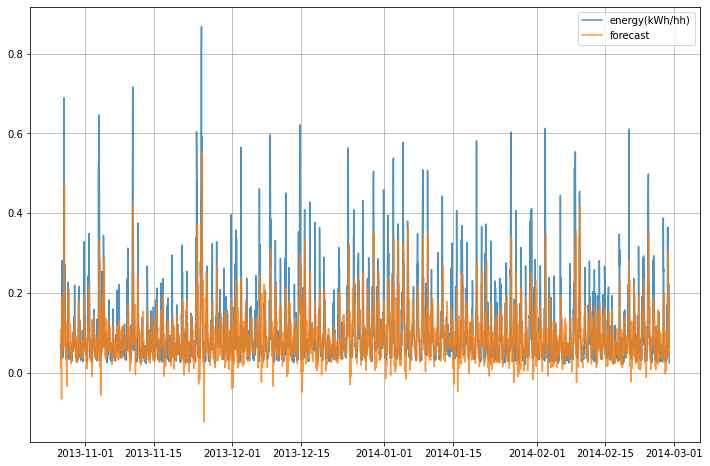

In [9]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_15523/2528746469.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


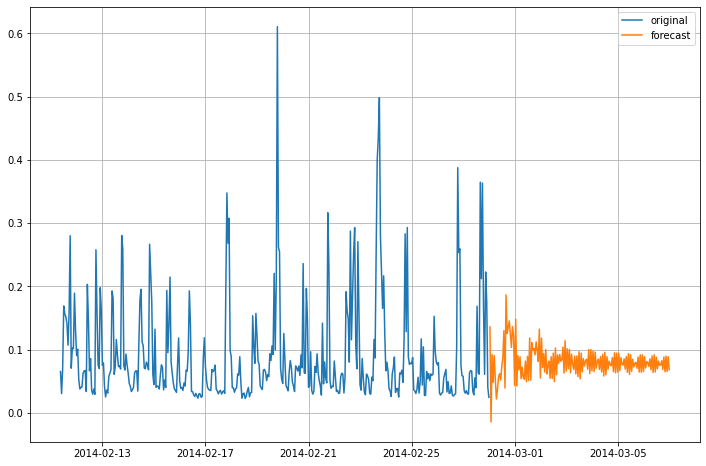

In [10]:

#Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [11]:
deep_learner.evaluateMSE()

0.006400841604971342

In [12]:
deep_learner.evaluateRMSE()

0.08000525985815772

In [13]:
deep_learner.evaluateMAE()

0.0517240871490868

In [14]:
deep_learner.evaluateMAPE()

63.506979180757504

In [15]:
yhat =deep_learner.predict()

In [16]:
yhat

[0.010429779,
 0.09286725,
 0.10824218,
 0.09324791,
 0.080762215,
 -0.066059895,
 0.19128543,
 0.052823007,
 0.09076255,
 0.085056104,
 0.07380707,
 0.13186482,
 0.060191996,
 0.09054182,
 0.09230261,
 0.14832923,
 0.1384136,
 0.31561133,
 0.19926262,
 0.47343728,
 0.24813852,
 0.18083805,
 0.06440307,
 0.15295921,
 0.15343705,
 0.09538636,
 0.07127588,
 0.03274302,
 0.12555405,
 0.05887402,
 -0.007926682,
 -0.03390555,
 0.097055085,
 0.12079963,
 0.04221395,
 0.109093174,
 0.076776765,
 0.111135215,
 0.15633084,
 0.2041541,
 0.13083759,
 0.20825166,
 0.09033766,
 0.0792541,
 0.07834592,
 0.124010034,
 0.084833525,
 0.044938788,
 0.07755482,
 0.061971724,
 0.025556505,
 0.023018455,
 0.0287508,
 0.05371441,
 0.071242735,
 0.067041054,
 0.079573326,
 0.04519579,
 0.05564747,
 0.05373507,
 0.08565896,
 0.093477316,
 0.101820715,
 0.058275282,
 0.06334799,
 0.07374228,
 0.06944603,
 0.09179715,
 0.06021832,
 0.08403496,
 0.13718829,
 0.07207872,
 0.106066816,
 0.07359035,
 0.038146116,
 